In [2]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
import datetime
from scipy.optimize import least_squares
#from tqdm import tqdm

In [3]:
# read two input images

ImT1_L = cv2.imread('./dataset/sequences/00/image_0/000000.png', 0)  # 0 flag returns a grayscale image
ImT1_R = cv2.imread('./dataset/sequences/00/image_1/000000.png', 0)

ImT2_L = cv2.imread('./dataset/sequences/00/image_0/000001.png', 0)
ImT2_R = cv2.imread('./dataset/sequences/00/image_1/000001.png', 0)

In [4]:
# we use this function to calculate the disparity using opencv functions.
def compute_left_disparity_map(img_left, img_right, matcher='bm', verbose=True):
    
    # parameters for opencv disparity functions
    sad_window = 6 # sum of absolutes (images)
    num_disparities = sad_window * 16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size)
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 1 * block_size ** 2,
                                        P2 = 32 * 1 * block_size ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
    
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}', end-start)
        
    return disp_left

Time to compute disparity map using StereoBM 0:00:00.136786


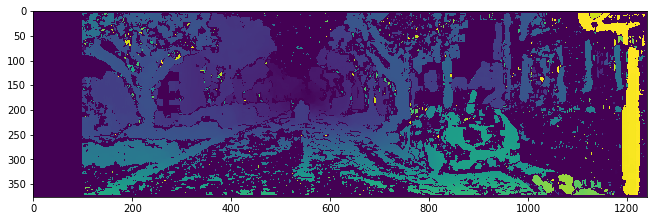

In [5]:
disp = compute_left_disparity_map(ImT1_L, ImT1_R,
                                  matcher='bm', verbose=True)
plt.figure(figsize=(11, 7))
plt.imshow(disp);

Time to compute disparity map using StereoSGBM 0:00:00.452290


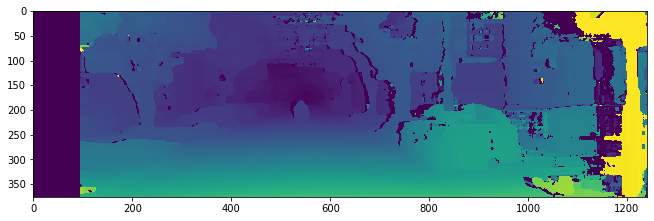

In [6]:
disp = compute_left_disparity_map(ImT1_L, ImT1_R,
                                  matcher='sgbm', verbose=True)
plt.figure(figsize=(11, 7))
plt.imshow(disp);

The rectangle at the left side is caused by the right camera. This is the space where the right camera does not see anything due to the baseline. Think that to calculate depth, we need an overlapping between the left camera and the right camera. However, there is some space in the right image that is not overlapping with the left image. This rectangle is useless.

In [7]:
disp[0, 0]

-1.0

In [8]:
print(disp[disp > 0].min()) # remember this later ****
print(disp[disp > 0].max())

0.5625
95.0


In [9]:
# get intrinsic and extrinsic matrices
calibFile = open('./dataset/sequences/00/calib.txt', 'r').readlines()
P1Vals = calibFile[0].split()
Proj1 = np.zeros((3,4))
for row in range(3):
    for column in range(4):
        Proj1[row, column] = float(P1Vals[row*4 + column + 1])

P2Vals = calibFile[1].split()
Proj2 = np.zeros((3,4))
for row in range(3):
    for column in range(4):
        Proj2[row, column] = float(P2Vals[row*4 + column + 1])

In [10]:
print(Proj1)

[[718.856    0.     607.1928   0.    ]
 [  0.     718.856  185.2157   0.    ]
 [  0.       0.       1.       0.    ]]


In [11]:
# k intrinsic, r rotation, t translation
k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(Proj2)
print(k)
print(r)
print((t/t[-1]).round(4))

[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 0.5372]
 [ 0.    ]
 [-0.    ]
 [ 1.    ]]


In [12]:
# create our decompose function to make it easy
def decompose_projection_matrix(p):
    
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[-1])[:3] #we normalize t to have a 1 value in the last element, then we only get x,y,z
    
    return k, r, t

In [13]:
def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
 
    if rectified:
        # calculate baseline : x right camera minus x left camera.
        b = t_right[0] - t_left[0]
    
    else:
        
        b = t_left[0] - t_right[0]
    
    # to calculate the focal length, we only take into account fx because we're working
    # with disparity (horizontal distances between one point seen in two images (stereo cameras))
    f = k_left[0][0]
    
    # to calculate depth, it is important to think about the minimum values of the disparity map.
    # Earlier we saw that the map has a rectangle with -1 values and, also, the map has 0 values. 
    # We don't want to divide by -1 nor 0. 
    
    # it is important to remember*** that the minimum value right after the last 0 value is 
    # 0.56... If we divide by 0, this point will not have any depth, but if we change 0 for 0.1,
    # this point will be very very far from the next further point (resulted by divided by 0.56...)
    disp_left[disp_left == 0.0] = 0.1
    # we do the same with -1 values
    disp_left[disp_left == -1.0] = 0.1
    
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [14]:
# decompose Proj1 and Proj2
k_left, r_left, t_left = decompose_projection_matrix(Proj1)
k_right, r_right, t_right = decompose_projection_matrix(Proj2)

In [15]:
depth_map = calc_depth_map(disp, k_left, t_left, t_right)

[[3861.44794246 3861.44794246 3861.44794246 ...    8.68961575
     8.68961575    8.68961575]
 [3861.44794246 3861.44794246 3861.44794246 ...    8.68961575
     8.68961575    8.68961575]
 [3861.44794246 3861.44794246 3861.44794246 ...    8.68961575
     8.68961575    8.68961575]
 ...
 [3861.44794246 3861.44794246 3861.44794246 ... 3861.44794246
  3861.44794246 3861.44794246]
 [3861.44794246 3861.44794246 3861.44794246 ... 3861.44794246
  3861.44794246 3861.44794246]
 [3861.44794246 3861.44794246 3861.44794246 ... 3861.44794246
  3861.44794246 3861.44794246]]


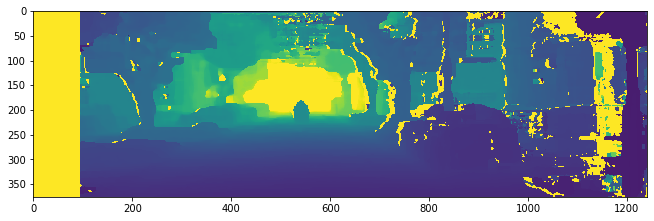

In [16]:
plt.figure(figsize=(11, 7))
print(depth_map)
# i'm using vmin and vmax to limit values and see the depth map more clear 
plt.imshow(depth_map, vmin=0, vmax=50);

Yellow colour is the points that are really far away from the camera.

In [17]:
depth_map.max()

3861.447942459941